In [1]:
from matplotlib import pyplot as plt
import os
import sys
import json
import pandas as pd
import numpy as np
from multiprocessing import Pool

abspath = os.path.abspath('.')
while not abspath.endswith('netscope'):
    abspath = os.path.dirname(abspath)
if abspath.endswith('netscope'):
    root_path = abspath
    print(root_path)
    os.chdir(root_path)
    sys.path.append(root_path)
    from analysis.load import Loader
    from analysis.ADR import ADR


markers = list('ov^<>12348sp*hH+xXDd|_.,')+[i for i in range(12)]

/home/user/dds/netscope


In [50]:

class ADR():
    def __init__(self, sigma_num=3, volumn=1e3):
        self.k = volumn  # 蓄水池的大小
        self.decay_rate = 0.8

        self.R = []  # reservoir
        self.R_sub = []
        self.c_w = 0  # current weight
        self.batch_count = 0  # batch size counter for batch-based decay
        self._decay_threshold = self.k / self.decay_rate  # batch-based decay threshold
        self.sigma_num = sigma_num
        # print(f"error bar: {sigma_num} sigma")

        self.abnormal_counter = 0  # continuous abnormal counter

    def observe(self, point, weight=1):
        self.decay()

        self.c_w += weight
        self.batch_count += 1

        prob = 0.8
        punish = 1
        # prob = self.k / (self.c_w + 1)  # with probability k/c_w
        punish = np.exp(self.abnormal_counter)  # punish if continuous abnormal

        if np.random.rand() < prob/punish:
            self.R.pop(np.random.randint(0, len(self.R)))
            self.R.append(point)
        # else:
        #     self.c_w += weight
        #     self.batch_count += 1

    def decay(self):
        if self.batch_count > self._decay_threshold:
            self.c_w *= self.decay_rate
            self.batch_count = 0


    def judge(self, point):
        layback = 0.99
        self.R_sub = self.R[:int(self.k*layback)]
        result = np.abs(point - np.median(self.R_sub)
                        ) > np.std(self.R_sub) * self.sigma_num

        # result = point > self.threshold()

        if result:
            self.abnormal_counter += 1
        else:
            self.abnormal_counter = 0
        return result

    def feed(self, point):
        if len(self.R) < self.k:  # init case
            self.R.append(point)
            return "unknow"
        else:
            judge = self.judge(point)
            self.observe(point, weight=1)
            if judge:
                return "out"
            else:
                return "in"


In [51]:
# 每个流各自一个ADR
def process_adr(flow_df):
    zoom = 1e3
    c_th = 5 # counter threshold
    flow_adr = ADR(volumn=len(flow_df)/10, sigma_num=10)
    for i, row in flow_df.iterrows():
        flow_df.loc[i, 'lier'] = flow_adr.feed(row['latency']/zoom)

        # if i > c_th and flow_adr.abnormal_counter < c_th:
        #     flow_df.loc[i-c_th, 'lier'] = 'in'
        
        if len(flow_adr.R_sub) > 0:
            adr_m = np.median(flow_adr.R_sub) * zoom 
            adr_std3 = np.std(flow_adr.R_sub) * flow_adr.sigma_num * zoom 
            adr_out = adr_std3 + adr_m
        else:
            adr_out = 0
            adr_m = 0
            adr_std3 = 0
        flow_df.loc[i, 'adr_out'] = adr_out

    return flow_df

def ad(hosts, digests):


    hosts_part = hosts[['timestamp', 'latency', 'path_str']].copy()
    ADR_df = pd.merge(hosts_part, digests, how='outer', on=['timestamp', 'latency', 'path_str'])
    estimate_df = ADR_df.copy(deep=True)
    new_rows = []
    for global_path_id, path_df in ADR_df.groupby(['global_path_id']):
    # for global_path_id in df.global_path_id.unique():
        # print(global_path_id)
        # path_df = df[df.global_path_id==global_path_id]#.reset_index(drop=True)
        timestamp_diff = path_df.timestamp.diff()
        for i, row in path_df.iterrows():
            if pd.isna(timestamp_diff[i]):
                continue
            count = int(row['path_count'])
            timestamps = np.linspace(row.timestamp - timestamp_diff[i], row.timestamp, 
                                    count+1)[1:-1] # 头尾数据已经存在，不需要再新增

            if count == 0:
                continue

            gause_rates = np.random.normal(1, 0.1, count-1)
            # print(i, row.path_count)
            for k in range(count-1):
                # print(k)
                new_row = row.copy(deep=True)
                new_row.timestamp = int(timestamps[k])
                new_row.latency *= gause_rates[k]
                new_rows.append(new_row)
                # estimate_df = estimate_df.append(new_row)
                
    estimate_df = pd.concat([estimate_df, pd.DataFrame(new_rows)])
    estimate_df = estimate_df.sort_values('timestamp').reset_index()

    paths = sorted(estimate_df['path_str'].unique())
    flow_dfs = {}
    for i, path in enumerate(paths):
        flow_dfs[path] = estimate_df[estimate_df['path_str']==path].copy(deep=True).reset_index(drop=True)

    



    with Pool(len(paths)) as p:
        map_dfs = p.map(process_adr, flow_dfs.values())
    map_df = pd.concat(map_dfs)
    return map_df

In [52]:
def cut(df, cut_len=2):
    df['epoch'] = pd.cut(df['receive_t'], cut_len, labels=list(range(cut_len)))
    df_L = []
    out_num = []
    for epoch, sdf in df.groupby(['epoch']):
        out_n = sdf.lier.tolist().count('out')
        out_num.append(out_n)
        # print(len(sdf))  
        df_L.append(len(sdf))  
    return out_num, df_L

In [53]:
log_base_dir = "/mnt/netscope/data/slot2/fattree4/burst/"
log_base_dir = "/mnt/netscope/data/slot2/fattree4/port_queue3/"
log_base_dir = "/mnt/netscope/data/slot2/fattree4/delay/"
log_base_dir = "/mnt/netscope/data/slot2/fattree4/ecmp_imbalance/"
out_nums = []
df_Ls = []
for exp_id in os.listdir(log_base_dir):
    print(end=".")
    log_dir = os.path.join(log_base_dir, exp_id)
    loader = Loader(log_dir)
    digests = loader.load_digest()
    hosts = loader.load_hosts(debug=True)
    base_t = hosts.timestamp.min()
    hosts_ = hosts[hosts.timestamp > base_t + 30e6]
    digests_ = digests[digests.timestamp > base_t + 30e6]
    
    df = ad(hosts_, digests_)
    
    start_t, end_t = df.timestamp.min(), df.timestamp.max()
    mid_t = (start_t - end_t)/2 + end_t
    
    cut_len = 3
    df['epoch'] = pd.cut(df['receive_t'], cut_len, labels=list(range(cut_len)))
    df_L = []
    out_num = []
    for epoch, sdf in df.groupby(['epoch']):
        out_n = sdf.lier.tolist().count('out')
        out_num.append(out_n)
        # print(len(sdf))  
        df_L.append(len(sdf))  
    out_nums.append(out_num)
    df_Ls.append(df_L)
    print(out_num, df_L)
    # break

.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of free

[30, 33, 27] [724, 1435, 1112]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/n

[1, 9, 8] [931, 1767, 1696]
.[0, 76, 89] [1320, 2517, 2047]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invali

[0, 40, 30] [579, 1796, 1938]
.[0, 35, 15] [1003, 2092, 2100]
.[3, 1, 20] [615, 1485, 1381]
.[0, 31, 101] [600, 1676, 1851]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0, 22, 70] [649, 1719, 1900]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of free

[0, 5, 18] [689, 1596, 1738]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0, 15, 29] [1054, 2088, 1868]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0, 59, 31] [879, 1665, 1738]
.[0, 85, 67] [504, 1506, 1754]
.[34, 160, 55] [952, 1847, 1910]
.[0, 15, 70] [922, 1989, 2062]
.[0, 7, 19] [1125, 2022, 1778]
.[0, 20, 33] [1062, 2219, 2135]
.[0, 9, 27] [1104, 1963, 1858]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/n

[0, 31, 20] [642, 1975, 1788]
.[0, 9, 11] [714, 1775, 1777]
.[0, 37, 68] [642, 1809, 1852]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invali

[5, 162, 191] [1050, 1603, 1731]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[17, 53, 42] [968, 1934, 2213]
.[0, 17, 48] [1027, 1456, 1800]
.[1, 26, 40] [527, 1629, 1861]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value e

[8, 15, 116] [623, 1077, 1434]
.[12, 33, 1] [915, 1947, 1453]
.[0, 140, 162] [469, 1647, 1352]
.[0, 25, 111] [1160, 2368, 2345]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.l

[0, 7, 87] [1353, 1999, 1232]
.[1, 76, 38] [995, 2141, 1555]
.

/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[2, 49, 0] [184, 368, 204]
.[37, 49, 42] [857, 1688, 1730]


In [30]:
# ad_dir = 'evaluation/other/anomalyDetection/data/'
# kind = 'ecmp'
# with open(os.path.join(ad_dir, f'np_{kind}_s10_num.txt'), 'w') as f:
#     np.savetxt(f, out_nums)
# with open(os.path.join(ad_dir, f'np_{kind}_s10_len.txt'), 'w') as f:
#     np.savetxt(f, df_Ls)

In [36]:
out_nums = np.array(out_nums)

In [39]:
out_nums_

array([[  8,  21,  14],
       [  5,   8,   3],
       [  0,  15,   7],
       [  0,  28,   8],
       [  0,  22,  11],
       [  3,  13,   9],
       [  1,  42,  30],
       [  0,  32,  18],
       [  3,  16,   9],
       [  2,  26,  15],
       [  0,  34,  10],
       [  0,  37,  23],
       [  9,  44,  24],
       [  0,  36,  22],
       [  0,   6,   6],
       [  0,  27,  13],
       [  1,  15,  11],
       [  2,  28,   9],
       [  1,   8,   1],
       [  0,  18,   4],
       [  1,  15,   7],
       [ 17,  32,  26],
       [  1,  22,  10],
       [  1,  28,  18],
       [  6,  45,  36],
       [  6,  21,   5],
       [  0, 112,  88],
       [  0,  28,   8],
       [  0,  69,  59],
       [  0,  28,   9],
       [  2,   8,   0],
       [  5,  18,   5]])

In [54]:
out_nums_ = np.array(out_nums)
out_nums_[:, 1] = out_nums_[:, 1] + out_nums_[:, 2]
hits = np.array(out_nums_) > 20
NUM = hits.shape[0]
true_negative = sum(hits[:, 0] == False)
true_positive = sum(hits[:, 1] == True)
print(true_negative, true_positive, NUM)

29 30 32


In [48]:
# log_base_dir = "/mnt/netscope/data/slot2/fattree4/burst/"
# log_base_dir = "/mnt/netscope/data/slot2/fattree4/port_queue3/"
threshold = 1e6

out_nums_S = []; df_Ls_S = []
for exp_id in os.listdir(log_base_dir):
    print(end=".")
    log_dir = os.path.join(log_base_dir, exp_id)
    loader = Loader(log_dir)
    hosts = loader.load_hosts()
    df = hosts
    df['lier'] = df['latency'].apply(lambda l: 'out' if l > threshold else 'in')
    out_num, df_L = cut(df)
    out_nums_S.append(out_num)
    df_Ls_S.append(df_L)
    # break

................................

In [49]:
hits_S = np.array(out_nums_S) > 20
NUM = hits_S.shape[0]
true_negative = sum(hits_S[:, 0] == False)
true_positive = sum(hits_S[:, 1] == True)
print(true_negative, true_positive, NUM)

0 32 32


In [60]:
hits[:, 1] == True

array([ True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True])

In [61]:
(hits[:, 1] == True).sum()


27

In [54]:
hits[:, 0] == False

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

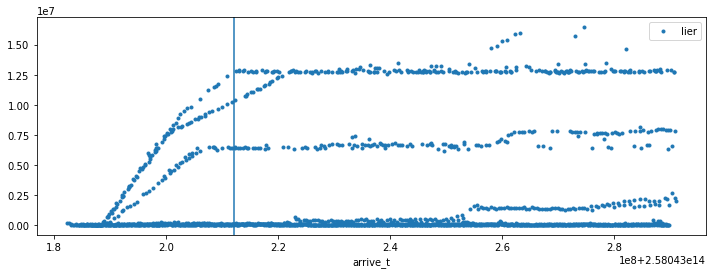

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 4)) 
hosts.plot('arrive_t', 'latency', ax=axes, label='lier', ls='', marker='.')
plt.axvline(hosts.timestamp.min() + 30e6)

KeyError: 'lier'

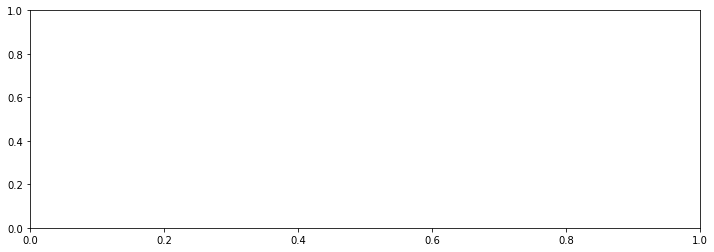

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 4)) 
for lier, sdf in hosts.groupby('lier'):
    sdf.plot('arrive_t', 'latency', ax=axes, label=lier, ls='', marker='.')
# plt.axvline(mid_t)